In [1]:
import mysql.connector
import pandas as pd
import os
from dotenv import load_dotenv
from sklearn.metrics import classification_report

import joblib

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
load_dotenv()

conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)

query = """
SELECT 
    id,
    travel_reason, 
    spontaneity 
FROM survey_responses
WHERE travel_reason IS NOT NULL;
"""

df = pd.read_sql(query, conn)

conn.close()

/var/folders/yz/shh48k7s5kg3qtp0x9hzjb6c0000gn/T/ipykernel_26938/3594635008.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
df

,id,travel_reason,spontaneity
0,14110,Budget-friendly,5
1,14111,Adventure,10
2,14112,Budget-friendly,7
3,14113,Self-discovery,4
4,14114,Cultural Immersion,7
...,...,...,...
1006,15116,Cultural Immersion,10
1007,15117,Adventure,8
1008,15118,Adventure,8
1009,15119,Budget-friendly,10


In [6]:
df.isnull().sum()

id               0
travel_reason    0
spontaneity      0
dtype: int64

In [7]:
df.groupby(['spontaneity', 'travel_reason'])['travel_reason'].count()


spontaneity  travel_reason     
0                                   2
1            Adventure             12
             Budget-friendly       17
             Cultural Immersion    21
             Relaxation            15
             Self-discovery        20
2            Adventure             18
             Budget-friendly       23
             Cultural Immersion    19
             Relaxation            17
             Self-discovery        15
3            Adventure             17
             Budget-friendly       17
             Cultural Immersion    26
             Relaxation            17
             Self-discovery        24
4            Adventure             22
             Budget-friendly       21
             Cultural Immersion    13
             Relaxation            26
             Self-discovery        18
5            Adventure             26
             Budget-friendly       21
             Cultural Immersion    30
             Relaxation            12
             Self-

In [8]:
df.groupby(['travel_reason', 'spontaneity'])['spontaneity'].count()

travel_reason       spontaneity
                    0               2
Adventure           1              12
                    2              18
                    3              17
                    4              22
                    5              26
                    6              18
                    7              19
                    8              17
                    9              17
                    10             20
Budget-friendly     1              17
                    2              23
                    3              17
                    4              21
                    5              21
                    6              19
                    7              24
                    8              28
                    9              23
                    10             27
Cultural Immersion  1              21
                    2              19
                    3              26
                    4              13
                  

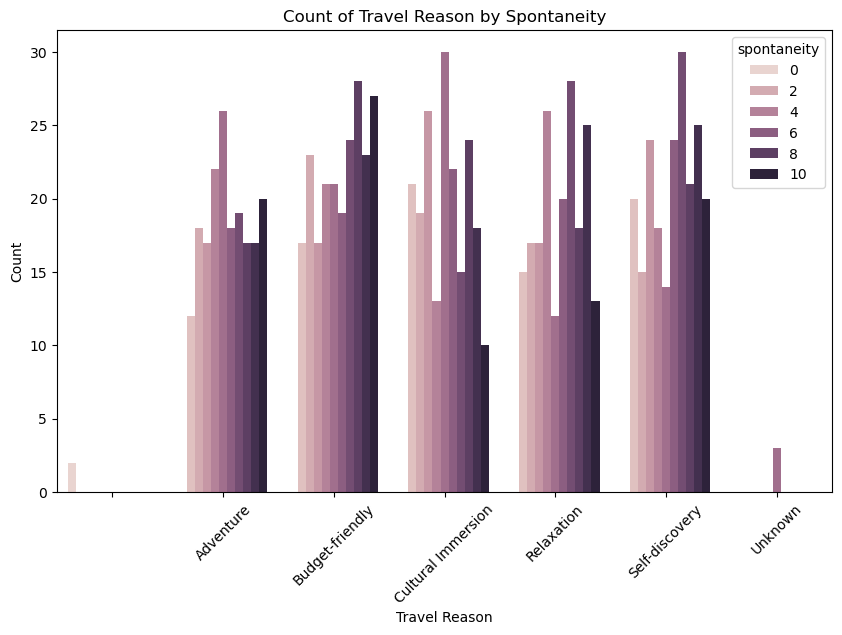

In [9]:
counts = df.groupby(['travel_reason', 'spontaneity']).size().reset_index(name='count')


plt.figure(figsize=(10, 6))
sns.barplot(x='travel_reason', y='count', hue='spontaneity', data=counts)

# Set plot labels and title
plt.title('Count of Travel Reason by Spontaneity')
plt.xlabel('Travel Reason')
plt.ylabel('Count')

# Show the plot
plt.xticks(rotation=45)
plt.show()

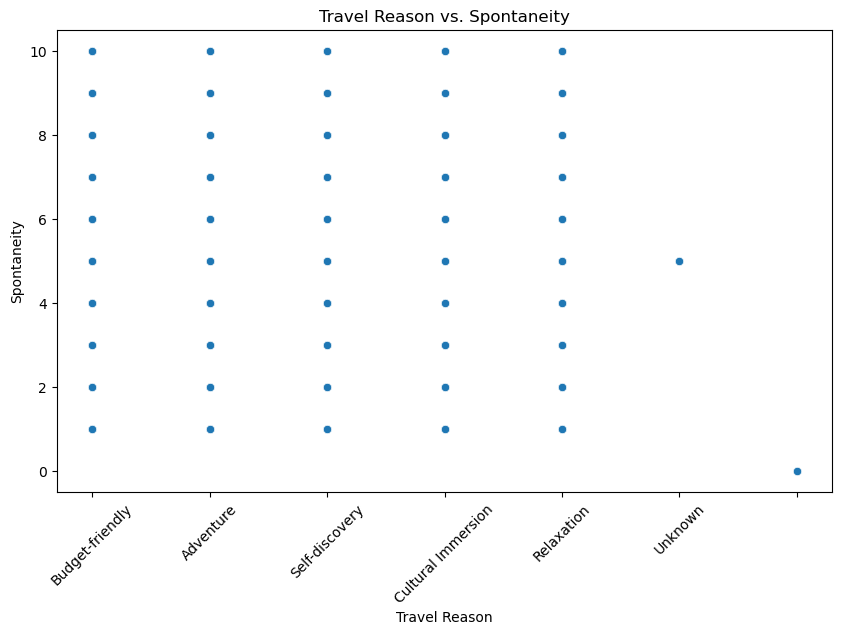

In [10]:
# Scatter plot to show the relationship between travel_reason and spontaneity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='travel_reason', y='spontaneity', data=df)

# Set plot labels and title
plt.title('Travel Reason vs. Spontaneity')
plt.xlabel('Travel Reason')
plt.ylabel('Spontaneity')

# Show the plot
plt.xticks(rotation=45)
plt.show()



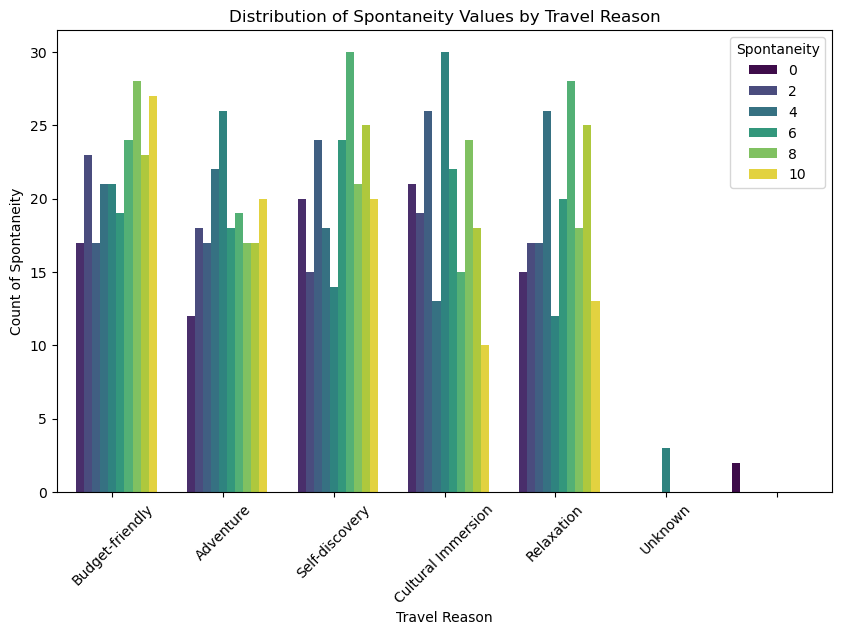

In [11]:
# Count plot to show the distribution of spontaneity values by travel_reason
plt.figure(figsize=(10, 6))
sns.countplot(x='travel_reason', hue='spontaneity', data=df, palette='viridis')

# Set plot labels and title
plt.title('Distribution of Spontaneity Values by Travel Reason')
plt.xlabel('Travel Reason')
plt.ylabel('Count of Spontaneity')

# Show the plot
plt.xticks(rotation=45)
plt.legend(title='Spontaneity')
plt.show()


In [12]:
df['travel_reason'].isnull().sum()

0

In [13]:
# # NORMALIZE 

# def normalize_categories(value):
#     if value and value != "":
#         return value.title()
#     return value

# df["travel_reason"] = df["travel_reason"].apply(normalize_categories)

In [14]:
X = df[['travel_reason', 'spontaneity']]

# OneHotEncoder for categorical 'travel_reason'
preprocessor = ColumnTransformer(
    transformers=[
        ('travel_reason', OneHotEncoder(), ['travel_reason']),
        ('spontaneity', 'passthrough', ['spontaneity'])
    ])


In [15]:
preprocessor

ColumnTransformer(transformers=[('travel_reason', OneHotEncoder(),
                                 ['travel_reason']),
                                ('spontaneity', 'passthrough',
                                 ['spontaneity'])])

In [16]:
# KMEANS CLUSTER

kmeans = KMeans(n_clusters=3)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', kmeans)])

pipeline.fit(X)

df['cluster'] = pipeline.predict(X)


In [17]:
from sklearn.metrics import silhouette_score

X_transformed = preprocessor.transform(X)

pipeline.fit(X)


df['cluster'] = pipeline.predict(X)

score = silhouette_score(X_transformed, df['cluster'])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.44508848796023354


In [18]:
df["travel_reason"].value_counts()

travel_reason
Budget-friendly       220
Self-discovery        211
Cultural Immersion    198
Relaxation            191
Adventure             186
Unknown                 3
                        2
Name: count, dtype: int64

In [19]:
df.groupby(["cluster", "travel_reason"])["spontaneity"].mean()


cluster  travel_reason     
0        Adventure             8.520548
         Budget-friendly       8.519608
         Cultural Immersion    8.343284
         Relaxation            8.273810
         Self-discovery        8.364583
1        Adventure             4.939394
         Budget-friendly       4.967213
         Cultural Immersion    5.138462
         Relaxation            4.896552
         Self-discovery        5.107143
         Unknown               5.000000
2                              0.000000
         Adventure             2.106383
         Budget-friendly       2.000000
         Cultural Immersion    2.075758
         Relaxation            2.040816
         Self-discovery        2.067797
Name: spontaneity, dtype: float64

In [20]:
df['cluster'].value_counts()

cluster
0    422
1    309
2    280
Name: count, dtype: int64

In [21]:
df[df["cluster"] == 1]["cluster"].iloc[2]

1

/var/folders/yz/shh48k7s5kg3qtp0x9hzjb6c0000gn/T/ipykernel_26938/1422433408.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="travel_reason", y="spontaneity", hue="cluster", ci=None)


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Budget-friendly'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Self-discovery'),
  Text(3, 0, 'Cultural Immersion'),
  Text(4, 0, 'Relaxation'),
  Text(5, 0, 'Unknown'),
  Text(6, 0, '')])

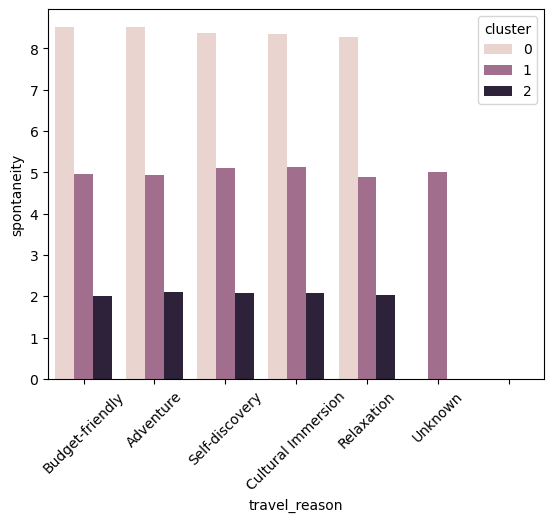

In [22]:
sns.barplot(data=df, x="travel_reason", y="spontaneity", hue="cluster", ci=None)
plt.xticks(rotation=45)


In [23]:
# EXPORT MODEL

joblib.dump(kmeans, '../pkl/clustering_model.pkl')
joblib.dump(pipeline, '../pkl/clustering_pipeline.pkl')

['../pkl/clustering_pipeline.pkl']

In [24]:
# Cluster 0 – The Free Spirits
# High spontaneity (around 9)
# Enjoy a mix of adventure, budget-friendly travel, cultural immersion, and relaxation
# Likely to make last-minute plans, embrace unexpected experiences, and thrive in flexible travel situations
# Could be backpackers, digital nomads, or thrill-seekers who don’t plan too far ahead

# Cluster 1 – The Planners
# Low spontaneity (around 2)
# Also enjoy all types of travel, but prefer structure and planned itineraries
# Likely to research destinations thoroughly, book in advance, and stick to schedules
# Could be families, business travelers, or those who prefer organized group tours

# Cluster 2 – The Balanced Travelers
# Medium spontaneity (around 6)
# A mix of planning and flexibility, depending on the trip type
# Likely to plan major aspects (flights, accommodations) but leave some room for spontaneity
# Could be solo travelers, couples, or travelers who like a mix of adventure and relaxation

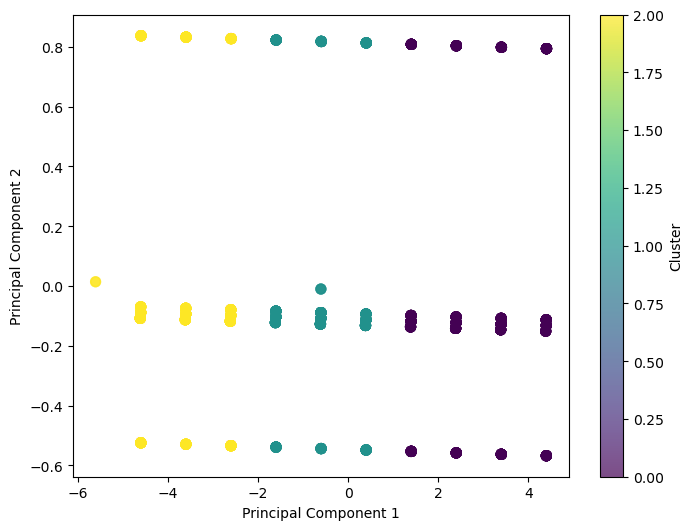

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract the features used for clustering
X = df[['travel_reason', 'spontaneity']]  # or however you processed it

# Apply OneHotEncoder to 'travel_reason' and other preprocessing steps
X_transformed = preprocessor.fit_transform(X)

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Visualize the 2D PCA representation of the data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
